In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import logging

import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from yass.config import Config
from yass.preprocessing import Preprocessor
from yass.neuralnet import NeuralNetDetector
from yass.mainprocess import Mainprocessor
from yass.deconvolute import Deconvolution
from yass.MFM import spikesort
from yass.preprocess.filter import butterworth

from neural_noise import config

logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt

/home/eduardo/miniconda3/envs/noise/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Running pipeline with triage NN

In [2]:
cfg = Config.from_yaml('../yass_config/server_49ch.yaml')

In [3]:
pp = Preprocessor(cfg)
pp_scores, clr_idx, spt = pp.process()

/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: class Preprocessor is deprecated: (Use function in preprocess module, see examples/preprocess.py)
  """Entry point for launching an IPython kernel.
INFO:yass.preprocessing:Preprocessing the data in progress...
/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/progressbar/bar.py:223: DeprecationWarning: The usage of `maxval` is deprecated, please use `max_value` instead
  '`max_value` instead', DeprecationWarning)
N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--INFO:yass.preprocessing:Preprocessing done in 51 seconds.
INFO:yass.preprocessing:	reading data:	0.742571 seconds
INFO:yass.preprocessing:	filtering:	11.021012 seconds
INFO:yass.preprocessing:	standardization:	0.98795 seconds
INFO:yass.preprocessing:	detection:	10.580681 seconds
INFO:yass.preprocessing:	whitening:	6.831828 seconds
INFO:yass.preprocessing:	saving recording:	0.922

In [4]:
mp = Mainprocessor(cfg,pp_scores,clr_idx,spt)
spike_train, spt_left = mp.mainProcess()

/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: class Mainprocessor is deprecated: (Use function in process module, see examples/process.py)
  """Entry point for launching an IPython kernel.
INFO:yass.mainprocess:Triaging...
INFO:yass.mainprocess:Coresettting...
INFO:yass.mainprocess:Masking...
INFO:yass.mainprocess:Clustering...
/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/progressbar/bar.py:223: DeprecationWarning: The usage of `maxval` is deprecated, please use `max_value` instead
  '`max_value` instead', DeprecationWarning)
100% (8 of 8) |###########################| Elapsed Time: 0:00:16 Time: 0:00:16
INFO:yass.mainprocess:Getting Templates...
100% (1 of 1) |###########################| Elapsed Time: 0:00:01 Time: 0:00:01
INFO:yass.mainprocess:Mainprocess done in 34 seconds.
INFO:yass.mainprocess:	triage:	0.818093 seconds
INFO:yass.mainprocess:	coreset:	6.116645 seconds
INFO:yass.mainprocess:	masking:	

Get recording

In [5]:
pp.openFile()
rec = pp.load(0,pp.config.batch_size)
rec = butterworth(rec, pp.config.filterLow,
                          pp.config.filterHighFactor,
                          pp.config.filterOrder,
                          pp.config.srate)
small_t = np.min((int(pp.config.srate*5), rec.shape[0]))
mid_T = int(np.ceil(rec.shape[0]/2))
rec_temp = rec[np.arange(mid_T-small_t, mid_T+small_t)]
sd = np.median(np.abs(rec), 0)/0.6745
rec = np.divide(rec,sd)

In [6]:
nnd = NeuralNetDetector(cfg)
proj = nnd.load_w_ae()

In [7]:
proj.shape

(31, 3)

In [8]:
def templates_in_feature_space(templates,proj):
    """Templates dimensionality reduction
    """
    R, nfeat = proj.shape
    nchannel, R, n_templates = templates.shape
    
    return np.transpose(np.reshape(
        np.matmul(np.reshape(np.transpose(templates,[0,2,1]),(-1,R)),proj),
        (nchannel, n_templates, nfeat)),(0,2,1))

In [9]:
def close_templates(templates, cluster_id, ncloseK):
    """Find similar templates by passing the cluster_id
    """
    nchan, R, nK = templates.shape
    close_to_far_idx = np.argsort(np.sum(np.square(templates - templates[:,:,[cluster_id]]),axis=(0,1)))
    return close_to_far_idx[:ncloseK]

In [10]:
spike_train.shape

(102564, 2)

In [12]:
cfg.neighChannels.sum(axis=1)

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4,
       4, 4, 4])

In [170]:
spt_clean = spike_train[:,0]
id_clean = spike_train[:,1]
templates = mp.templates
cluster_id = 2
n_cluster_plot = 5
neighbor = cfg.neighChannels
plot_length = 15
plot_width = 10
cols = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plot_name1 = 'waveform.pdf'
plot_name2 = 'scatter_score.pdf'
plot_wf = False
plot_score = 1

In [14]:
# get parameters
R, nfeat = proj.shape
spike_size = int((R-1)/2)
nchannel, R, n_templates = templates.shape

# dimension reduction of templates
templates_in_feature = templates_in_feature_space(templates,proj)

# find similar templates to template in cluster_id, this will give us overlapping
# clusters
k_idx = close_templates(templates_in_feature, cluster_id, n_cluster_plot)

In [15]:
def find_reduced_template(cluster_id):
    """
    Load template with a given cluster_id but only load neighboring channels
    """
    # find the template for cluster_id
    t_interest = templates[:,:,cluster_id]

    # find the main channel for that template
    c_main = np.argmax(np.max(t_interest,axis=1))

    # find neighbors for that channel
    ch_idx = np.where(neighbor[c_main])[0]
        
    return templates[ch_idx, :, cluster_id]

In [16]:
def find_reduced_similar_templates(cluster_id, k_similar):
    template_ids = close_templates(templates_in_feature, cluster_id, k_similar)
    reduced_templates = np.vstack([find_reduced_template(cid) for cid in template_ids])
    return reduced_templates, np.array(template_ids)

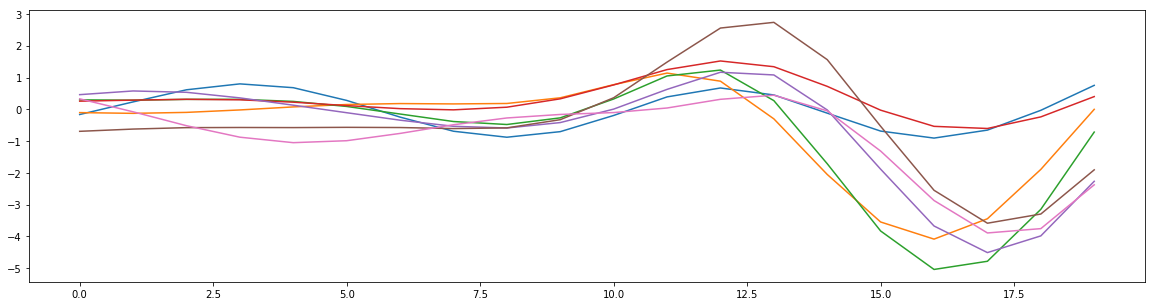

In [17]:
# get_waveforms_and_scores_for_template is breaking because of a spike at time 5999986
plt.rcParams['figure.figsize'] = (20, 5)
plt.plot(rec[5999986-10:5999986+10, [ 1  ,5 , 9 ,12 ,17, 20 ,24]])

In [150]:
nchannel, R, n_templates = templates.shape

def get_waveforms_and_scores_for_template(template_id, flatten=True):
    """
    Return the waveform for a given template
    
    Parameters
    ----------
    flatten: bool
        flatten waveforms along channels
    """
    # get times for spikes whose id correspond the template_id
    spt_k = spt_clean[id_clean == template_id]
        
    # get the number of waveforms used to build that template
    nn = spt_k.shape[0]
    
    # find main channel and neighboring channels
    t_interest = templates[:,:,template_id]
    c_main = np.argmax(np.max(t_interest,axis=1))
    ch_idx = np.where(neighbor[c_main])[0]
    
    print('gid', template_id,'ch', c_main, 'neigh', len(ch_idx))
    
    # get the waveforms
    wf = np.zeros((nn, R, ch_idx.shape[0]))

    for j in range(nn):
        try:
            wf[j] = rec[(spt_k[j]-spike_size):(spt_k[j]+spike_size+1),ch_idx]
        except Exception as e:
#             print(spt_k[j])
            pass

    # also get the scores
    score = np.transpose(np.reshape(np.matmul(
        np.reshape(np.transpose(wf,(0,2,1)),(-1, R)),proj),(nn,ch_idx.shape[0],nfeat)),(0,2,1))
    
    if flatten:
        wf = np.reshape(wf, [wf.shape[0], -1])
        score = np.reshape(score, [score.shape[0], -1])
    
    return wf, score

In [151]:
templates.shape

(49, 31, 114)

In [152]:
for i in range(114):
    wf, score = get_waveforms_and_scores_for_template(i)
    wf.shape, score.shape

gid 0 ch 9 neigh 7
gid 1 ch 38 neigh 5
gid 2 ch 46 neigh 4
gid 3 ch 38 neigh 5
gid 4 ch 31 neigh 5
gid 5 ch 35 neigh 5
gid 6 ch 39 neigh 5
gid 7 ch 24 neigh 7
gid 8 ch 17 neigh 7
gid 9 ch 9 neigh 7
gid 10 ch 9 neigh 7
gid 11 ch 35 neigh 5
gid 12 ch 46 neigh 4
gid 13 ch 17 neigh 7
gid 14 ch 38 neigh 5
gid 15 ch 31 neigh 5
gid 16 ch 24 neigh 7
gid 17 ch 38 neigh 5
gid 18 ch 39 neigh 5
gid 19 ch 42 neigh 4
gid 20 ch 9 neigh 7
gid 21 ch 42 neigh 4
gid 22 ch 24 neigh 7
gid 23 ch 31 neigh 5
gid 24 ch 31 neigh 5
gid 25 ch 10 neigh 7
gid 26 ch 13 neigh 7
gid 27 ch 18 neigh 7
gid 28 ch 18 neigh 7
gid 29 ch 32 neigh 5
gid 30 ch 5 neigh 7
gid 31 ch 13 neigh 7
gid 32 ch 47 neigh 4
gid 33 ch 36 neigh 5
gid 34 ch 47 neigh 4
gid 35 ch 6 neigh 7
gid 36 ch 47 neigh 4
gid 37 ch 0 neigh 7
gid 38 ch 10 neigh 7
gid 39 ch 18 neigh 7
gid 40 ch 10 neigh 7
gid 41 ch 47 neigh 4
gid 42 ch 39 neigh 5
gid 43 ch 32 neigh 5
gid 44 ch 28 neigh 6
gid 45 ch 21 neigh 7
gid 46 ch 43 neigh 4
gid 47 ch 39 neigh 5
gid 48 ch

In [133]:
np.max(t_interest,axis=1)

array([ 0.14893305,  0.10945607,  0.16004184,  0.0840795 ,  0.08644352,
        0.18167364,  0.19891214,  0.2585774 ,  0.07784519,  0.21002093,
        0.2840795 ,  0.42035565,  0.07018828,  0.17119247,  0.06372385,
        1.7991841 ,  0.27569037,  0.11751046,  0.14253138,  0.87658996,
        0.07627615,  0.17748954,  0.02608787,  0.87485356,  0.14972803,
        0.06410042,  0.12767782,  0.10997908,  0.16100418,  1.74236401,
        1.11495816,  0.42085774,  0.1240795 ,  4.42985356,  0.46638075,
        0.12004184,  0.14089959,  0.12740586,  0.12079498,  0.18380753,
        0.15993724,  0.57301255,  0.06648536,  0.17451883,  0.13169456,
        0.38135983,  0.0874477 ,  0.30855648,  0.08167364])

In [154]:
def get_waveforms_and_scores_for_templates(templates, flatten=True):
    """
    Return waveforms and scores for a group of templates
    along with a vector that indicates the cluster_id for each
    one
    """
    res = [get_waveforms_and_scores_for_template(template_id, flatten=flatten) for template_id in templates]
    wfs = np.vstack([t[0] for t in res])
    scores = np.vstack([t[1] for t in res])
    labels = np.hstack([np.ones(len(l[0]))*t for l, t in zip(res, templates)])
    return wfs, scores, labels

In [155]:
wfs, score, labels = get_waveforms_and_scores_for_templates(np.unique(id_clean), flatten=False)

gid 0 ch 9 neigh 7
gid 1 ch 38 neigh 5
gid 2 ch 46 neigh 4
gid 3 ch 38 neigh 5
gid 4 ch 31 neigh 5
gid 5 ch 35 neigh 5
gid 6 ch 39 neigh 5
gid 7 ch 24 neigh 7
gid 8 ch 17 neigh 7
gid 9 ch 9 neigh 7
gid 10 ch 9 neigh 7
gid 11 ch 35 neigh 5
gid 12 ch 46 neigh 4
gid 13 ch 17 neigh 7
gid 14 ch 38 neigh 5
gid 15 ch 31 neigh 5
gid 16 ch 24 neigh 7
gid 17 ch 38 neigh 5
gid 18 ch 39 neigh 5
gid 19 ch 42 neigh 4
gid 20 ch 9 neigh 7
gid 21 ch 42 neigh 4
gid 22 ch 24 neigh 7
gid 23 ch 31 neigh 5
gid 24 ch 31 neigh 5
gid 25 ch 10 neigh 7
gid 26 ch 13 neigh 7
gid 27 ch 18 neigh 7
gid 28 ch 18 neigh 7
gid 29 ch 32 neigh 5
gid 30 ch 5 neigh 7
gid 31 ch 13 neigh 7
gid 32 ch 47 neigh 4
gid 33 ch 36 neigh 5
gid 34 ch 47 neigh 4
gid 35 ch 6 neigh 7
gid 36 ch 47 neigh 4
gid 37 ch 0 neigh 7
gid 38 ch 10 neigh 7
gid 39 ch 18 neigh 7
gid 40 ch 10 neigh 7
gid 41 ch 47 neigh 4
gid 42 ch 39 neigh 5
gid 43 ch 32 neigh 5
gid 44 ch 28 neigh 6
gid 45 ch 21 neigh 7
gid 46 ch 43 neigh 4
gid 47 ch 39 neigh 5
gid 48 ch

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [156]:
wfs.shape, score.shape, labels.shape

((5811, 31, 5), (397, 15), (5811,))

In [157]:
wfs, score, labels = get_waveforms_and_scores_for_templates([1,2,3], flatten=False)

gid 1 ch 38 neigh 5
gid 2 ch 46 neigh 4
gid 3 ch 38 neigh 5


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [158]:
wfs.shape, score.shape, labels.shape

((5811, 31, 5), (397, 15), (5811,))

In [159]:
def pca_plot(data, colors):
    """
    Reduce dimensionality using PCA
    and plot data
    """
    pca = PCA(n_components=2)

    pca.fit(data)
    reduced = pca.transform(data)
    
    for color in np.unique(colors).astype('int'):
        plt.scatter(reduced[colors == color, 0], reduced[colors == color, 1], label=color, alpha=0.7)

    plt.legend()
    plt.show()
    

In [160]:
def lda_plot(data, colors, ax=None):
    """
    Reduce dimensionality using LDA
    and plot data
    """
    ax = plt if ax is None else ax

    lda = LDA(n_components=2)
    lda.fit(data, colors)
    reduced = lda.transform(data)

    for color in np.unique(colors).astype('int'):
        ax.scatter(reduced[colors == color, 0], reduced[colors == color, 1],
                    label='Cluster {}'.format(color), alpha=0.7)

    ax.legend()

In [161]:
def visualize_cluster(cluster_id, k_similar, ax=None):
    """
    Project in 2D a cluster id along with k_similar
    clusters
    """
    template_ids = close_templates(templates_in_feature, cluster_id, k_similar+1)
    wf, scores, labels = get_waveforms_and_scores_for_templates(template_ids)
    lda_plot(scores, labels, ax=ax)

gid 1 ch 38 neigh 5
gid 17 ch 38 neigh 5
gid 14 ch 38 neigh 5


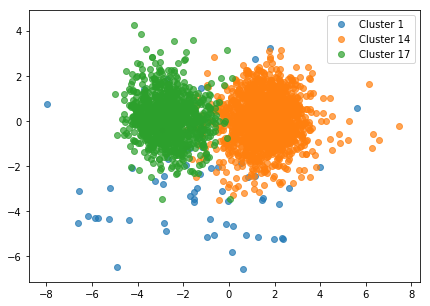

In [162]:
plt.rcParams['figure.figsize'] = (7,5)
visualize_cluster(1, 2)

In [163]:
cluster_ids = np.unique(id_clean)

In [164]:
len(cluster_ids)

114

In [165]:
wf, score = get_waveforms_and_scores_for_template(1)
wf.shape, score.shape

gid 1 ch 38 neigh 5


((58, 155), (58, 15))

gid 0 ch 9 neigh 7
gid 22 ch 24 neigh 7
gid 8 ch 17 neigh 7
gid 1 ch 38 neigh 5
gid 17 ch 38 neigh 5
gid 14 ch 38 neigh 5
gid 2 ch 46 neigh 4
gid 12 ch 46 neigh 4
gid 11 ch 35 neigh 5


ValueError: all the input array dimensions except for the concatenation axis must match exactly

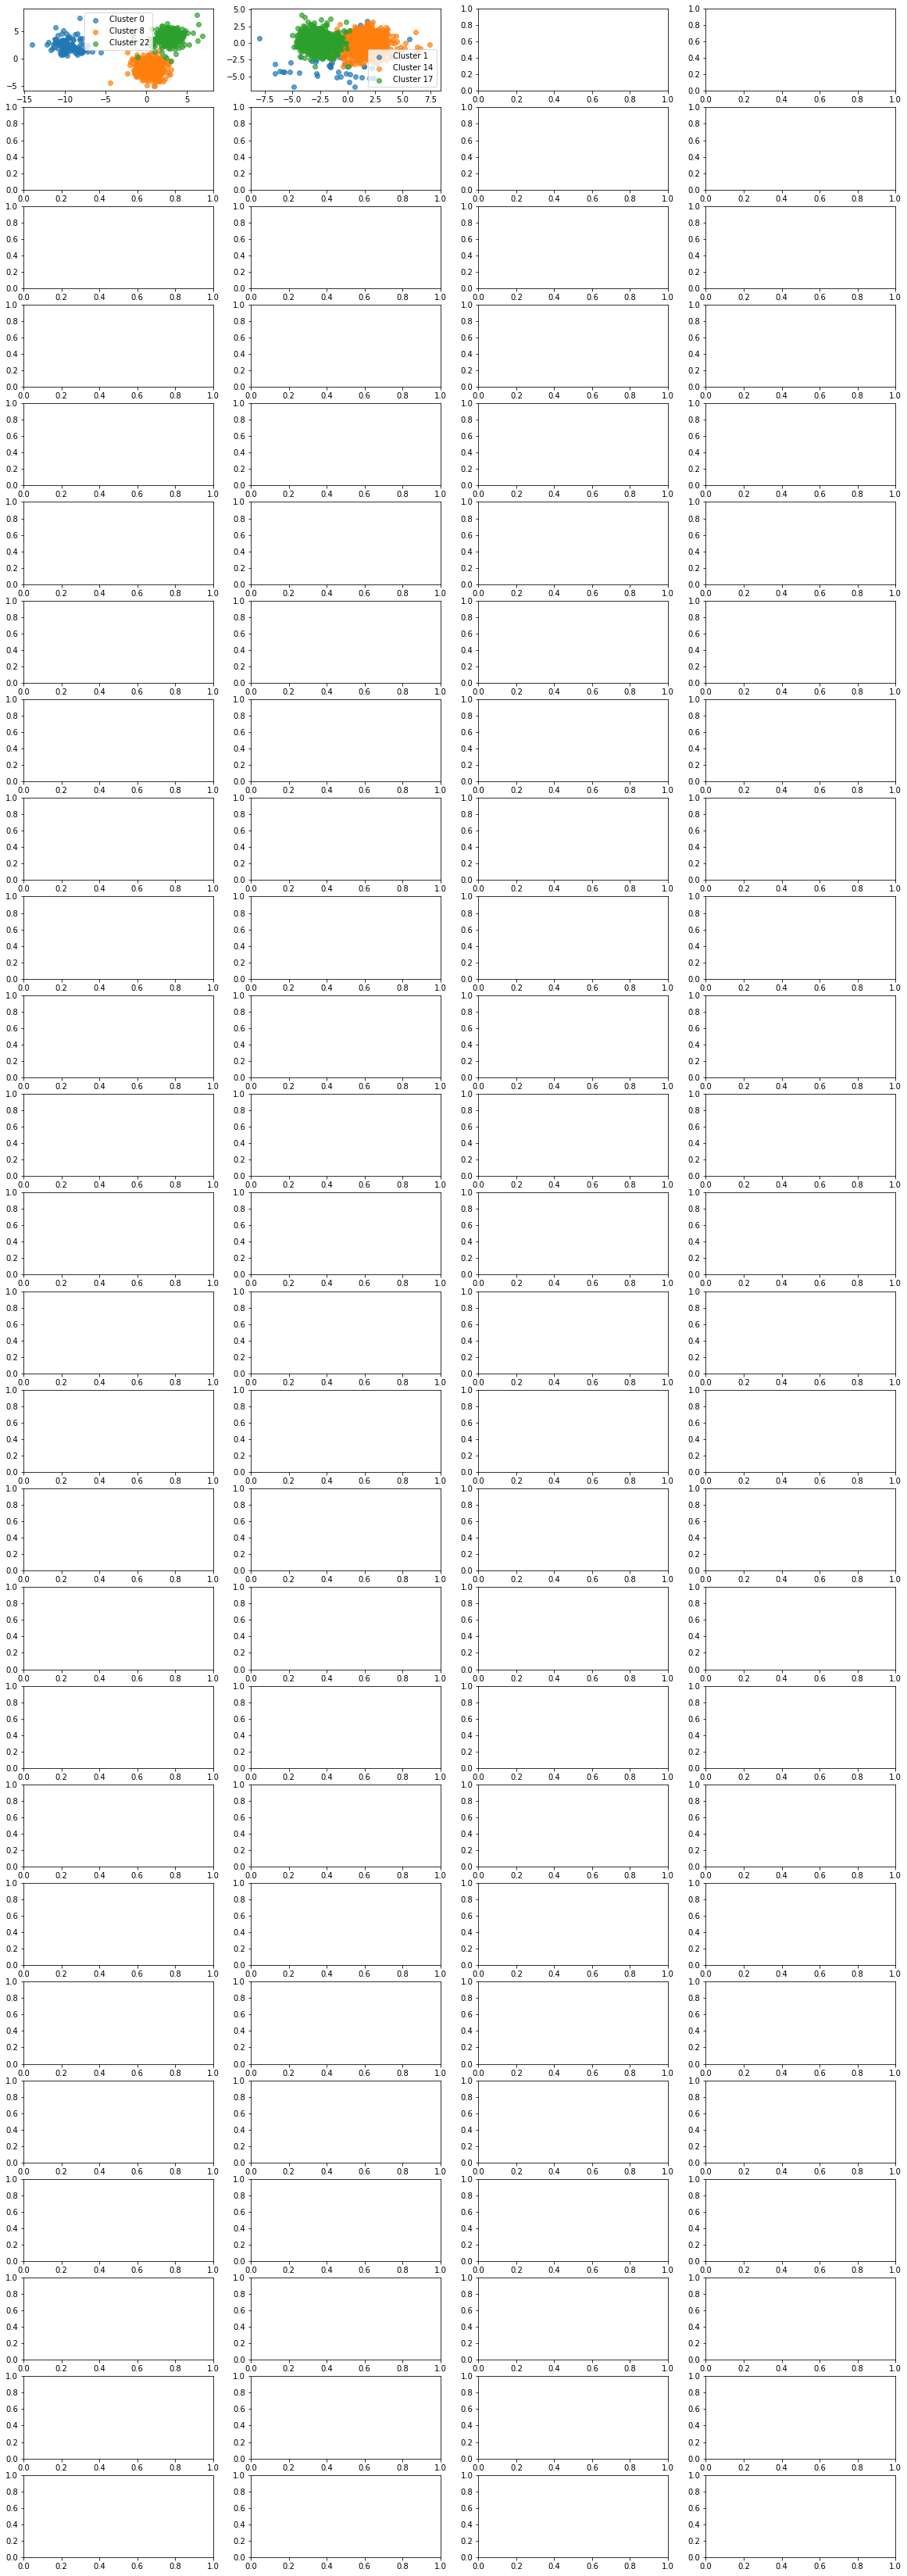

In [166]:
plt.rcParams['figure.figsize'] = (20, 60)
f, axs = plt.subplots(26, 4)
axs = [item for sublist in axs for item in sublist]

for ax, cluster_id in zip(axs, cluster_ids):
    visualize_cluster(cluster_id, k_similar=2, ax=ax)

# plt.savefig('lda.png')

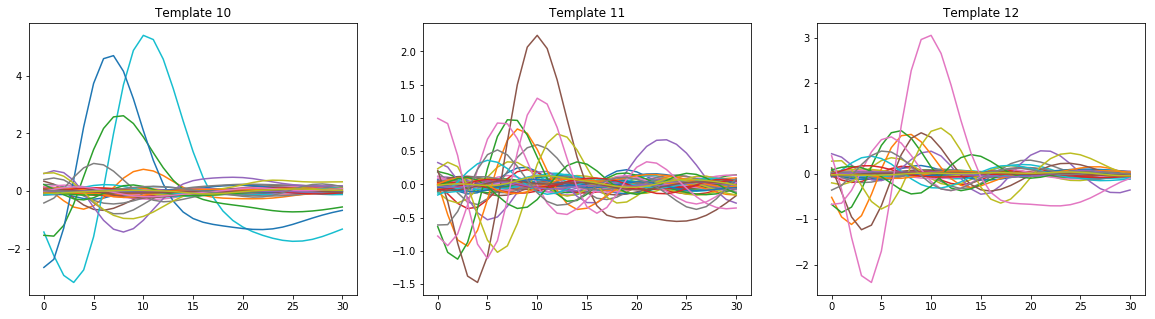

In [167]:
plt.rcParams['figure.figsize'] = (20, 5)
f, axs = plt.subplots(1, 3)

for cluster_id, ax in zip((10,11,12), axs):
    ax.plot(templates[:, :, cluster_id].T)
    ax.set_title('Template {}'.format(cluster_id))

plt.legend()
# plt.savefig('wf1.pdf')
plt.show()

In [195]:
templates_in_feature.shape

(49, 3, 114)

In [196]:
templates_in_feature[0].shape

(3, 114)

In [197]:
def plot_cluster(rec, proj, spt_clean, id_clean, templates, cluster_id, 
                 n_cluster_plot, neighbor, plot_length, plot_width, cols, plot_name1, plot_name2, plot_wf, plot_score):
    
    # get parameters
    R, nfeat = proj.shape
    spike_size = int((R-1)/2)
    nchannel, R, n_templates = templates.shape

#     print('templates raw', templates.shape)
    
    # dimension reduction of templates
    templates_in_feature = templates_in_feature_space(templates,proj)
    
#     print('templates in ft', templates_in_feature.shape)
        
        
    # choose neighboring templates
    k_idx = close_templates(templates_in_feature, cluster_id, n_cluster_plot)
    
#     print('cluster id', cluster_id, 'similar clusters', k_idx)

    # find main channel and neighboring channels
    t_interest = templates[:,:,cluster_id]
    
#     print('t interest', t_interest.shape)

    c_main = np.argmax(np.max(t_interest,axis=1))
    ch_idx = np.where(neighbor[c_main])[0]
    
    
    print('id', cluster_id, 'main', c_main, 'neigh tmps', len(k_idx), 'neigh ch', len(ch_idx))

    # get waveforms for all
    wf_all = list()
    score_all = list()
    for k in k_idx:
        # find clear spike times whose cluster_id is the template we are looking for
        # this are the ones that were used to build the template
        spt_k = spt_clean[id_clean == k]
        
        # get the number of waveforms used to build that template
        nn = spt_k.shape[0]
#         print('nn', nn)
        
        # look for those waveforms
        wf = np.zeros((nn, R, ch_idx.shape[0]))
        for j in range(nn):
            wf[j] = rec[(spt_k[j]-spike_size):(spt_k[j]+spike_size+1),ch_idx]

        score = np.transpose(np.reshape(np.matmul(
            np.reshape(np.transpose(wf,(0,2,1)),(-1, R)),proj),(nn,ch_idx.shape[0],nfeat)),(0,2,1))

        wf_all.append(wf)
        score_all.append(score)
    
    max_val = np.max(templates[ch_idx][:,:,k_idx])*3
    min_val = np.min(templates[ch_idx][:,:,k_idx])*3

    # plot waveforms
    if plot_wf:
        count = 1
        time_val = np.arange(R)/20.
        fig = plt.gcf()
        fig.set_size_inches(plot_length, plot_width)
        fig.suptitle("Cluster of interest: " + str(cluster_id)+", main channel: "+str(c_main), fontsize=16)
        for c in range(ch_idx.shape[0]):
            for k in range(k_idx.shape[0]):
                plt.subplot(ch_idx.shape[0],k_idx.shape[0],count)
                plt.plot(time_val,wf_all[k][:,:,c].T)
                plt.plot(time_val,np.mean(wf_all[k][:,:,c], axis=0), linewidth = 5, color='red')
                plt.ylim((min_val,max_val))
                if k == 0:
                    plt.ylabel('channel '+str(ch_idx[c]))
                if c == ch_idx.shape[0]-1:
                    plt.xlabel('time (ms)')
                if c == 0:
                    plt.title('cluster '+str(k_idx[k]))
                count += 1
        plt.savefig(plot_name1)
        plt.show()
    
    
    if plot_score:
#         print('templates...', ch_idx)
#         print(templates_in_feature[ch_idx][:,:,k_idx].shape)
        tt = np.transpose(templates_in_feature[ch_idx][:,:,k_idx],(2,1,0))
#         print(tt.shape)
        tt = np.reshape(tt,[tt.shape[0],-1])
#         print(tt.shape)

        pca = PCA(n_components=2)
        pca.fit(tt)
        
#         lda = LDA(n_components=2)
#         lda.fit(tt, range(tt.shape[0]))

        fig = plt.gcf()
        fig.set_size_inches(10, 10)
        for k in range(k_idx.shape[0]):
#             print('scores for', k, k_idx[k])
            score_temp = np.reshape(score_all[k],(score_all[k].shape[0],-1))
#             print(score_temp.shape)
            score_temp = pca.transform(score_temp)
#             score_temp = lda.transform(score_temp)
#             print(score_temp.shape)
            plt.scatter(score_temp[:,0],score_temp[:,1],color=cols[k])

        legend_name = [None]*k_idx.shape[0]
        for k in range(k_idx.shape[0]):
            legend_name[k] = "Cluster "+str(k_idx[k])

        plt.legend(legend_name)
        plt.xlabel('Dimension 0')
        plt.ylabel('Dimension 1')
        plt.savefig(plot_name2)
#         plt.show()
        
    
    

id 0 main 9 neigh tmps 5 neigh ch 7
id 1 main 38 neigh tmps 5 neigh ch 5
id 2 main 46 neigh tmps 5 neigh ch 4
id 3 main 38 neigh tmps 5 neigh ch 5
id 4 main 31 neigh tmps 5 neigh ch 5
id 5 main 35 neigh tmps 5 neigh ch 5
id 6 main 39 neigh tmps 5 neigh ch 5
id 7 main 24 neigh tmps 5 neigh ch 7
id 8 main 17 neigh tmps 5 neigh ch 7
id 9 main 9 neigh tmps 5 neigh ch 7
id 10 main 9 neigh tmps 5 neigh ch 7
id 11 main 35 neigh tmps 5 neigh ch 5
id 12 main 46 neigh tmps 5 neigh ch 4
id 13 main 17 neigh tmps 5 neigh ch 7
id 14 main 38 neigh tmps 5 neigh ch 5
id 15 main 31 neigh tmps 5 neigh ch 5
id 16 main 24 neigh tmps 5 neigh ch 7
id 17 main 38 neigh tmps 5 neigh ch 5
id 18 main 39 neigh tmps 5 neigh ch 5
id 19 main 42 neigh tmps 5 neigh ch 4
id 20 main 9 neigh tmps 5 neigh ch 7
id 21 main 42 neigh tmps 5 neigh ch 4
id 22 main 24 neigh tmps 5 neigh ch 7
id 23 main 31 neigh tmps 5 neigh ch 5
id 24 main 31 neigh tmps 5 neigh ch 5
id 25 main 10 neigh tmps 5 neigh ch 7
id 26 main 13 neigh tmps 5

ValueError: could not broadcast input array from shape (29,7) into shape (31,7)

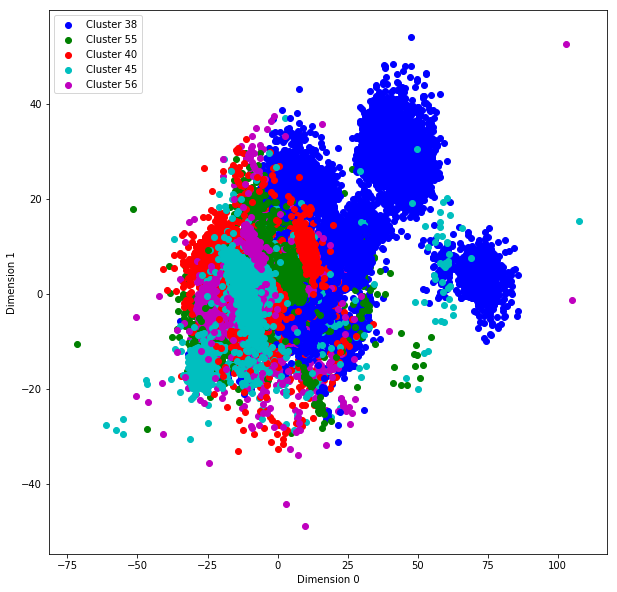

In [198]:
for i in range(110):
    cluster_id=i
    plot_cluster(rec, proj, spt_clean, id_clean, templates, cluster_id, 
             n_cluster_plot, neighbor, plot_length, plot_width, cols, plot_name1, plot_name2, plot_wf, plot_score)

id 46 main 43 neigh tmps 5 [46 51 44 93 11] neigh ch [21 28 39 43]


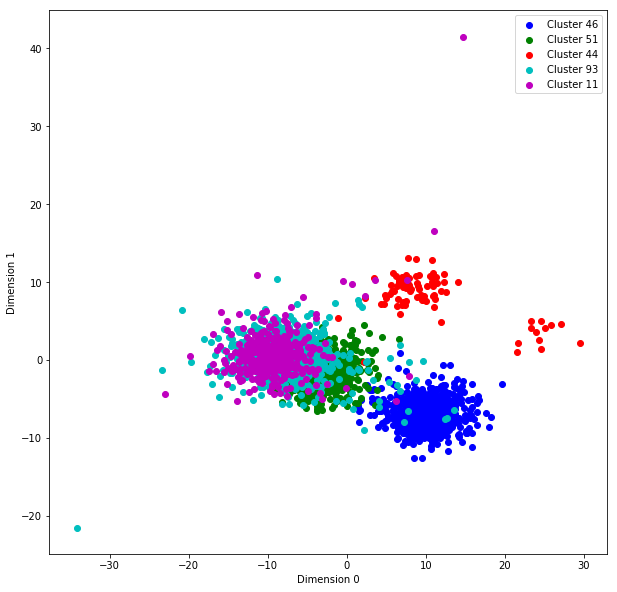

In [190]:
plot_cluster(rec, proj, spt_clean, id_clean, templates, 46, 
             n_cluster_plot, neighbor, plot_length, plot_width, cols, plot_name1, plot_name2, plot_wf, plot_score)